## Datset preparation

In [27]:
# convert both dataset to standardized form, they should both contain:
# 1) variables: ['PR', 'TM', 'TX', 'TN']
# 2) "EPSG:31468" crs
# 2) coordinates: ['time', 'northing', 'easting'] # depends on crs

In [2]:
import os
import pathlib
import affine

In [3]:
import cartopy
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import xarray as xr

In [4]:
### helper functions

In [5]:
from typing import List

In [49]:
def plot_samples_espg_crs(samples: List[xr.DataArray], figsize=(5, 5)) -> None:
    fig = plt.figure(figsize=figsize)
    for idx, sample in enumerate(samples):
        ax = fig.add_subplot(1, len(samples), idx + 1, projection=cartopy.crs.epsg(31468))
        sample.plot(ax=ax, center=0, cmap="coolwarm")
        ax.add_feature(cartopy.feature.BORDERS)
        ax.add_feature(cartopy.feature.STATES, linestyle=":")
        ax.add_feature(cartopy.feature.RIVERS)
    
    plt.tight_layout()
    plt.show()

### Rekis dataset

In [7]:
### join all rekis data into one large dataset containing all variables.

In [8]:
base_path = "../../ReKIS/KlimRefDS_v3.1_1961-2023/Raster/Tag/GK4/"
variables = os.listdir(base_path)

In [9]:
print(f"available variables: {variables}")

available variables: ['RK', 'RR', 'TM', 'TX', 'TN']


In [10]:
variables.remove("RR") # remove rain rate

In [11]:
dataset_dict = {}
for variable in variables:
    dataset_dict[variable] = xr.open_mfdataset(
        f"{base_path}/{variable}/*.nc",
        decode_coords="all",
    )[variable]

rekis = xr.Dataset(dataset_dict)

In [12]:
rekis

<xarray.Dataset>
Dimensions:   (easting: 418, northing: 401, time: 23010)
Coordinates:
  * easting   (easting) float64 4.336e+06 4.336e+06 ... 4.752e+06 4.752e+06
  * northing  (northing) float64 5.954e+06 5.954e+06 ... 5.556e+06 5.554e+06
  * time      (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2023-12-31
    crs       int32 -2147483647
Data variables:
    RK        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TM        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TX        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>
    TN        (time, northing, easting) float32 dask.array<chunksize=(365, 401, 418), meta=np.ndarray>

In [13]:
### slice data

In [14]:
rekis = rekis.isel(
    easting=slice(0, 400),
    northing=slice(0, 400)
)

In [15]:
### display sample

In [16]:
sample_date = "2000-01-01"

In [32]:
y_rekis_tm = rekis["TM"]
y_rekis_tm_sample = y_rekis_tm.sel(time=sample_date)

In [33]:
y_rekis_tm_sample

<xarray.DataArray 'TM' (northing: 400, easting: 400)>
dask.array<getitem, shape=(400, 400), dtype=float32, chunksize=(400, 400), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 4.336e+06 4.336e+06 ... 4.734e+06 4.734e+06
  * northing  (northing) float64 5.954e+06 5.954e+06 ... 5.556e+06 5.556e+06
    time      datetime64[ns] 2000-01-01
    crs       int32 -2147483647
Attributes:
    units:      °C
    long_name:  mittlere Temperatur

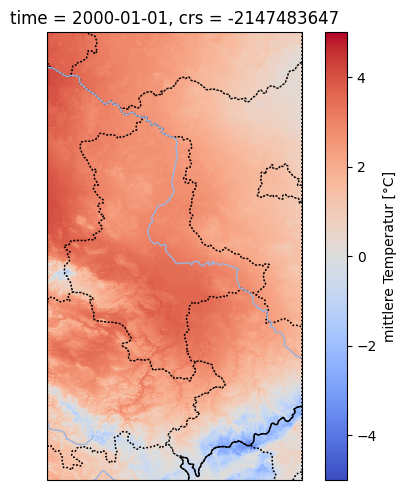

In [34]:
plot_samples_espg_crs([y_rekis_tm_sample])

In [20]:
import threading
import time

In [21]:
num_threads = threading.active_count()
print(f"Number of active threads: {num_threads}")

Number of active threads: 10


In [25]:
### upscale rekis dataset

In [22]:
start = time.time()
rekis.rio.set_spatial_dims("easting", "northing")
x_rekis = rekis.rio.reproject(
    rekis.rio.crs, 
    resolution=(10_000, 10_000), 
    resampling=rasterio.enums.Resampling.cubic_spline,
    num_threads=10
)
end = time.time()

print(f"Time diff: {(end - start) / 60} min")

Time diff: 18.178899470965067 min


In [28]:
x_rekis

<xarray.Dataset>
Dimensions:  (x: 40, y: 40, time: 23010)
Coordinates:
  * x        (x) float64 4.34e+06 4.35e+06 4.36e+06 ... 4.72e+06 4.73e+06
  * y        (y) float64 5.95e+06 5.94e+06 5.93e+06 ... 5.57e+06 5.56e+06
  * time     (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2023-12-31
    crs      int64 0
Data variables:
    RK       (time, y, x) float32 0.0 0.0 0.0 0.0 ... 1.18 1.413 1.613 1.575
    TM       (time, y, x) float32 2.967 3.051 3.144 3.131 ... 2.924 2.967 2.944
    TX       (time, y, x) float32 3.678 3.762 3.872 3.896 ... 6.229 6.469 6.571
    TN       (time, y, x) float32 nan nan nan nan ... -0.9338 -0.9599 -1.009

In [66]:
x_rekis_tm_sample = x_rekis['TM'].sel(time=sample_date)

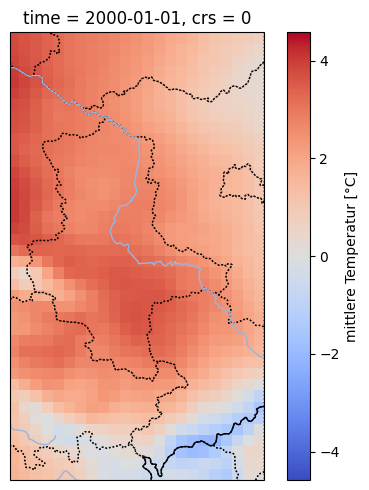

In [67]:
plot_samples_espg_crs([x_rekis_tm_sample])

In [109]:
rename_dict = {"RK": "PR"}
rekis = rekis.rename(rename_dict)
rekis.keys()

KeysView(<xarray.Dataset>
Dimensions:   (easting: 400, northing: 400, time: 23010)
Coordinates:
  * easting   (easting) float64 4.336e+06 4.336e+06 ... 4.734e+06 4.734e+06
  * northing  (northing) float64 5.954e+06 5.954e+06 ... 5.556e+06 5.556e+06
  * time      (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2023-12-31
    crs       int32 -2147483647
Data variables:
    PR        (time, northing, easting) float32 dask.array<chunksize=(365, 400, 400), meta=np.ndarray>
    TM        (time, northing, easting) float32 dask.array<chunksize=(365, 400, 400), meta=np.ndarray>
    TX        (time, northing, easting) float32 dask.array<chunksize=(365, 400, 400), meta=np.ndarray>
    TN        (time, northing, easting) float32 dask.array<chunksize=(365, 400, 400), meta=np.ndarray>)

In [ ]:
rekis.to_netcdf("/home/kostape4/downscale/data/rekis/rekis.nc")

### Cordex dataset

In [83]:
### Join all cordex data into one large dataset containg all variables.

In [84]:
# regional climate model to downscale
rcm = "GERICS-REMO2015_v1_day"

In [85]:
base_path = "../../CORDEX/"
variables = os.listdir(base_path)

In [86]:
print(f"available variables: {variables}")

available variables: ['tas', 'orog', 'tasmin', 'pr', 'sftlf', 'tasmax', 'mrso']


In [87]:
remove = ["orog", "sftlf", "mrso"]
variables = [var for var in variables if var not in remove]

In [88]:
dataset_dict = {}
for variable in variables:
    dataset_dict[variable] = xr.open_mfdataset(
        f"{base_path}/{variable}/*{rcm}*.nc",
        decode_coords="all",
    )[variable]

cordex = xr.Dataset(dataset_dict)

In [89]:
cordex

<xarray.Dataset>
Dimensions:                     (time: 12418, rlat: 412, rlon: 424)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-02T12:00:00 ......
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
    rotated_latitude_longitude  int32 -2147483647
    lat                         (rlat, rlon) float32 22.02 22.06 ... 66.83 66.76
    lon                         (rlat, rlon) float32 -10.14 -10.04 ... 64.95
    height                      float64 2.0
Data variables:
    tas                         (time, rlat, rlon) float32 dask.array<chunksize=(730, 412, 424), meta=np.ndarray>
    tasmin                      (time, rlat, rlon) float32 dask.array<chunksize=(730, 412, 424), meta=np.ndarray>
    pr                          (time, rlat, rlon) float32 dask.array<chunksize=(730, 412, 424), meta=np.ndarray>
    tasmax                      (time, rlat, rlon) float32 dask.array<chunksize=(730, 412, 424), meta=np.ndarray>

In [ ]:
rename_dict = {
    "tas": "TM",
    "tasmin": "TN",
    "tasmax": "TX",
    ""
}

In [90]:
### reproject cordex dataset to match the rekis dataset

In [106]:
start = time.time()
cordex_1d = cordex.drop_vars(["lat", "lon"])
espg_cordex = cordex_1d.rio.reproject(
    dst_crs="EPSG:31468",
    transform=affine.Affine(10000.0, 0.0, 4335000.0, 0.0, -10000.0, 5955000.0),
    shape=(40, 40),
    resampling=rasterio.enums.Resampling.cubic_spline,
)
end = time.time()

print(f"Time diff: {(end - start) / 60}min")

Time diff: 4.477633198102315min


In [92]:
x_cordex_tm_sample = espg_cordex_tm.sel(time=sample_date + "T12:00:00")
x_cordex_tm_sample -= 273.15

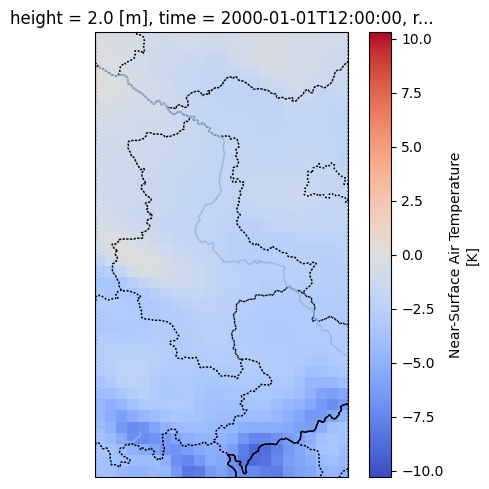

In [93]:
plot_samples_espg_crs([x_cordex_tm_sample])

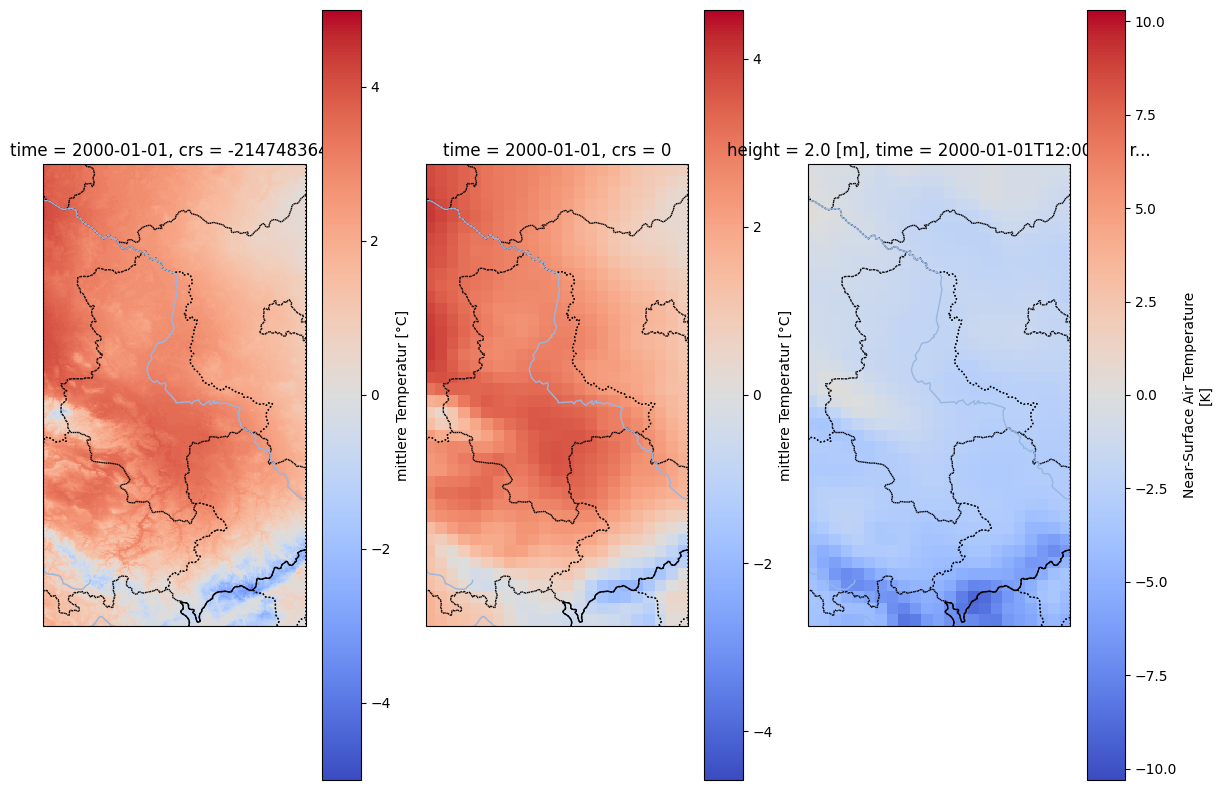

In [98]:
plot_samples_espg_crs([y_rekis_tm_sample, x_rekis_tm_sample, x_cordex_tm_sample], figsize=(12, 8))

In [101]:
### data samples

In [104]:
rekis_test_sample = rekis.sel(time=slice("2000-01-01", "2000-02-01"))
rekis_test_sample.to_netcdf("rekis_test_sample.nc")